In [1]:
import pandas as pd
import os
import glob
import numpy as np
from numpy import loadtxt
from openpyxl import load_workbook

In [2]:
path_unfamiliar = "/Users/gregorycrooks/Desktop/Dissertation Data/Unfamiliar"
path_lying = "/Users/gregorycrooks/Desktop/Dissertation Data/Lying"
path_true = "/Users/gregorycrooks/Desktop/Dissertation Data/True"

csv_files_unfamiliar = np.sort(glob.glob(os.path.join(path_unfamiliar, "*.csv")))
csv_files_lying = np.sort(glob.glob(os.path.join(path_lying, "*.csv")))
csv_files_true = np.sort(glob.glob(os.path.join(path_true, "*.csv")))



In [3]:
import warnings
warnings.filterwarnings("ignore")

def load_file(path, participant_ind, filter=["TP9", "TP10", "P9", "P10"]):
    data = pd.read_fwf(path, skiprows = 1)
    out = []

    dfs_out = []
    for ind, i in enumerate(range((data.shape[0]+614)//614)):
        out += [i+1]*614

        start_value = i*614
        end_value = start_value+610

        df = data.iloc[start_value:end_value]
        df.iloc[:]["trial_ind"] = i+1
        df['participant_id'] = participant_ind
        dfs_out.append(df)
        
    data = pd.concat(dfs_out)
    new_df = {column:[] for column in data.columns}

    for i in range(data.shape[0]//61):
        if i*61+61>data.shape[0]:
            break

        temp_data = data.iloc[i*61:i*61+61, :].mean(axis=0)
        
        for item in temp_data.index:
            new_df[item].append(temp_data[item])
    
    return pd.DataFrame.from_dict(new_df)[filter]


In [4]:
unfamiliar_data = []
for ind, path in enumerate(csv_files_unfamiliar):
    print(F'\rUnfamiliar: {ind}/{len(csv_files_unfamiliar)}', end='')
    unfamiliar_data.append(load_file(path, ind+1))
print('')
lying_data = []
for ind, path in enumerate(csv_files_lying):
    print(F'\rLying: {ind}/{len(csv_files_lying)}', end='')
    lying_data.append(load_file(path, ind+1))
print('')

true_data = []
for ind, path in enumerate(csv_files_true):
    print(F'\rTrue: {ind}/{len(csv_files_true)}', end='')
    true_data.append(load_file(path, ind+1))
print('')


Unfamiliar: 18/19
Lying: 18/19
True: 18/19


In [5]:
split_value = 10

unfamiliar_train, unfamiliar_test = unfamiliar_data[:split_value], unfamiliar_data[split_value:] 
lying_train, lying_test = lying_data[:split_value], lying_data[split_value:] 
true_train, true_test = true_data[:split_value], true_data[split_value:] 

### Logistic Regression

In [6]:
unfamiliar_train[0].shape

(400, 4)

In [7]:
from matplotlib import pyplot as plt
X_unf = np.vstack(unfamiliar_train) # label 0
X_unf = np.hstack((np.vstack(unfamiliar_train), np.zeros((X_unf.shape[0], 1))))
X_lying = np.vstack(lying_train)    # label 1
X_lying = np.hstack((np.vstack(lying_train), np.ones((X_lying.shape[0], 1))))
X_true = np.vstack(true_train)      # label 2
X_true = np.hstack((np.vstack(true_train), 2*np.ones((X_true.shape[0], 1))))
data = np.vstack((X_unf, X_lying, X_true))
X_train = data[:, :-1]
y_train = data[:, -1]


In [8]:
print(len(X_train))

10780


In [9]:
X_unf = np.vstack(unfamiliar_test) # label 0
X_unf = np.hstack((np.vstack(unfamiliar_test), np.zeros((X_unf.shape[0], 1))))
X_lying = np.vstack(lying_test)    # label 1
X_lying = np.hstack((np.vstack(lying_test), np.ones((X_lying.shape[0], 1))))
X_true = np.vstack(true_test)      # label 2
X_true = np.hstack((np.vstack(true_test), 2*np.ones((X_true.shape[0], 1))))
data = np.vstack((X_unf, X_lying, X_true))
X_test = data[:, :-1]
y_test = data[:, -1]


In [10]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import accuracy_score
LR = LogisticRegression()
LR_fit = LR.fit(X_train, y_train)
LR_pred = LR_fit.predict(X_test)
print("Logistic Regression is %f percent accurate" % (accuracy_score(LR_pred, y_test)*100))


# this one classifies each millisecond, then takes the average over each millisecond

Logistic Regression is 35.125881 percent accurate


In [11]:
from scipy import stats
X_test_grouped = unfamiliar_test+lying_test+true_test

preds = []
labels = [0]*len(unfamiliar_test)+[1]*len(lying_test)+[2]*len(true_test)

X_test_grouped = unfamiliar_test+lying_test+true_test

preds = []
labels = [0]*len(unfamiliar_test)+[1]*len(lying_test)+[2]*len(true_test)
for item, label in zip(X_test_grouped, labels):
    preds.append(stats.mode(LR_fit.predict(item))[0][0])

In [12]:
from scipy import stats
X_test_grouped = unfamiliar_test+lying_test+true_test

preds = []
labels = [0]*len(unfamiliar_test)+[1]*len(lying_test)+[2]*len(true_test)
for item, label in zip(X_test_grouped, labels):
    preds.append(stats.mode(LR_fit.predict(item))[0][0])


# this one predicts each millisecond, but for each participant, it takes the mode for that participant of every millisecond
# so the most frequent poredicted value, and uses that value to classify that participant into lying, unfamiliar, true 

In [13]:
for pred, label in zip(preds, labels):
    print(f"Prediction: {pred}, label: {label}")
    pass
accuracy = (np.array(preds)==np.array(labels)).mean()*100
print(f"accuracy: {accuracy}%")

Prediction: 0.0, label: 0
Prediction: 0.0, label: 0
Prediction: 0.0, label: 0
Prediction: 0.0, label: 0
Prediction: 0.0, label: 0
Prediction: 0.0, label: 0
Prediction: 0.0, label: 0
Prediction: 2.0, label: 0
Prediction: 2.0, label: 0
Prediction: 0.0, label: 1
Prediction: 2.0, label: 1
Prediction: 2.0, label: 1
Prediction: 0.0, label: 1
Prediction: 0.0, label: 1
Prediction: 0.0, label: 1
Prediction: 1.0, label: 1
Prediction: 2.0, label: 1
Prediction: 2.0, label: 1
Prediction: 0.0, label: 2
Prediction: 2.0, label: 2
Prediction: 2.0, label: 2
Prediction: 0.0, label: 2
Prediction: 0.0, label: 2
Prediction: 0.0, label: 2
Prediction: 1.0, label: 2
Prediction: 2.0, label: 2
Prediction: 2.0, label: 2
accuracy: 44.44444444444444%


[Text(0, 0.5, 'Unfamiliar'), Text(0, 1.5, 'Lie'), Text(0, 2.5, 'True')]

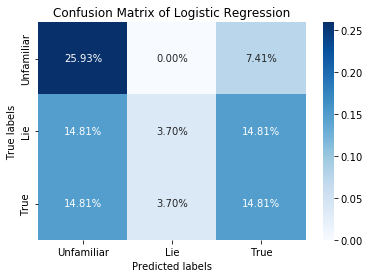

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
cf_matrix_lr = confusion_matrix(labels, preds)
sns.heatmap(cf_matrix_lr/np.sum(cf_matrix_lr), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Logistic Regression'); 
ax.xaxis.set_ticklabels(['Unfamiliar', 'Lie', 'True']); ax.yaxis.set_ticklabels(['Unfamiliar', 'Lie', 'True'])


### Neural network

In [15]:
shapes = []
for item in [unfamiliar_train, lying_train, true_train, unfamiliar_test, lying_test, true_test]:
    for array in item:
        shapes.append(array.shape[0])
print()
min_shape = min(shapes)


X_unf = np.stack([item.values[:min_shape, :] for item in unfamiliar_train]) # label 0
X_lying = np.stack([item.values[:min_shape, :] for item in lying_train])    # label 1
X_true = np.stack([item.values[:min_shape, :] for item in true_train])      # label 2

data = np.vstack((X_unf, X_lying, X_true))
X_train = data
y_train = np.array([0]*X_unf.shape[0]+[1]*X_lying.shape[0]+[2]*X_true.shape[0])

X_unf = np.stack([item.values[:min_shape, :] for item in unfamiliar_test]) # label 0
X_lying = np.stack([item.values[:min_shape, :] for item in lying_test])    # label 1
X_true = np.stack([item.values[:min_shape, :] for item in true_test])      # label 2

data = np.vstack((X_unf, X_lying, X_true))
X_test = data
y_test = np.array([0]*X_unf.shape[0]+[1]*X_lying.shape[0]+[2]*X_true.shape[0])

print(f"X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}, y_test.shape: {y_test.shape}")


X_train.shape: (30, 250, 4), X_test.shape: (27, 250, 4)
y_train.shape: (30,), y_test.shape: (27,)


In [33]:
from sklearn.preprocessing import StandardScaler

SS = StandardScaler()
X_train_NN = SS.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_NN  = SS.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_train_NN = y_train
y_test_NN = y_test


In [34]:
n_0 = min_shape
n_1 = 4
import keras
from keras import Sequential
from keras.layers import Conv1D
from keras import layers
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=(n_0, n_1)))
model.add(keras.layers.Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPooling1D(2))
model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(100, "relu"))
model.add(keras.layers.Dense(100, "relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(3, "softmax"))

import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(X_train_NN, y_train_NN, epochs=100, batch_size=18, validation_data=(X_test_NN, y_test_NN))

Epoch 1/100
2/2 [==============================] - 2s 280ms/step - loss: 1.0995 - accuracy: 0.4667 - val_loss: 1.1136 - val_accuracy: 0.3333
Epoch 2/100
2/2 [==============================] - 0s 98ms/step - loss: 1.1761 - accuracy: 0.4000 - val_loss: 1.1046 - val_accuracy: 0.3704
Epoch 3/100
2/2 [==============================] - 0s 87ms/step - loss: 1.3388 - accuracy: 0.3667 - val_loss: 1.1005 - val_accuracy: 0.3704
Epoch 4/100
2/2 [==============================] - 0s 79ms/step - loss: 1.5193 - accuracy: 0.2667 - val_loss: 1.1000 - val_accuracy: 0.3704
Epoch 5/100
2/2 [==============================] - 0s 65ms/step - loss: 1.2362 - accuracy: 0.3333 - val_loss: 1.0990 - val_accuracy: 0.3704
Epoch 6/100
2/2 [==============================] - 0s 109ms/step - loss: 1.1617 - accuracy: 0.4667 - val_loss: 1.0975 - val_accuracy: 0.2963
Epoch 7/100
2/2 [==============================] - 0s 114ms/step - loss: 1.3678 - accuracy: 0.3333 - val_loss: 1.0958 - val_accuracy: 0.3333
Epoch 8/100
2/2 [

The accuracy score for this CNN is 34.7008547008547 %


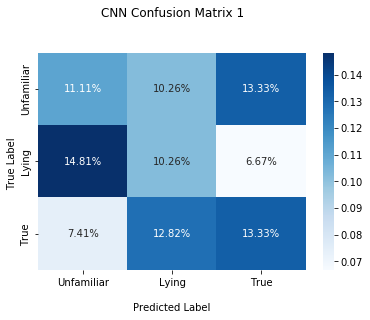

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

y_predictions = model.predict(
    x = X_test_NN
)
rounded_predictions = np.argmax(y_predictions, axis = 1)
cm = confusion_matrix(y_test, rounded_predictions, normalize='pred')
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_title('CNN Confusion Matrix 1\n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label ');
ax.xaxis.set_ticklabels(['Unfamiliar','Lying','True'])
ax.yaxis.set_ticklabels(['Unfamiliar','Lying','True'])

perc_acc = np.array(cm/np.sum(cm)).flatten()
acc_score = perc_acc[0] + perc_acc[4] + perc_acc[8]
print('The accuracy score for this CNN is', acc_score*100, '%')

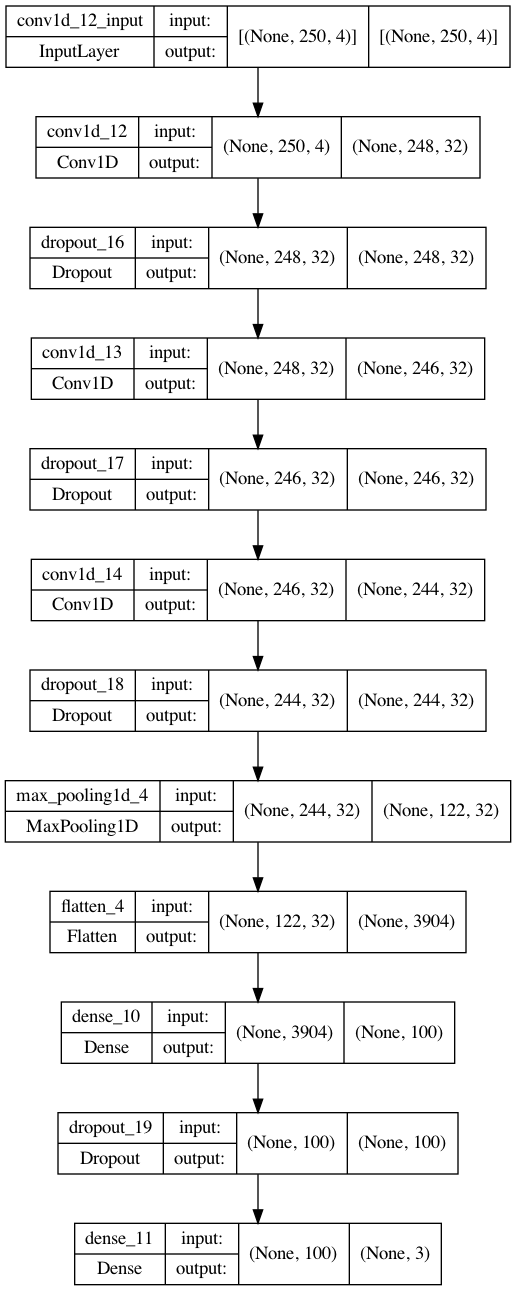

In [36]:

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 248, 32)           416       
                                                                 
 dropout_16 (Dropout)        (None, 248, 32)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 246, 32)           3104      
                                                                 
 dropout_17 (Dropout)        (None, 246, 32)           0         
                                                                 
 conv1d_14 (Conv1D)          (None, 244, 32)           3104      
                                                                 
 dropout_18 (Dropout)        (None, 244, 32)           0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 122, 32)         

In [38]:
n_0 = min_shape
n_1 = 4
import keras
from keras import Sequential
from keras.layers import Conv1D
from keras import layers
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=(n_0, n_1)))
model.add(keras.layers.Dropout(0.7))
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(keras.layers.Dropout(0.7))
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(keras.layers.Dropout(0.7))
model.add(keras.layers.MaxPooling1D(2))
model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(100, "relu"))
model.add(keras.layers.Dense(100, "relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(3, "softmax"))

import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(X_train_NN, y_train_NN, epochs=100, batch_size=18, validation_data=(X_test_NN, y_test_NN))

Epoch 1/100
2/2 [==============================] - 1s 598ms/step - loss: 2.1680 - accuracy: 0.3667 - val_loss: 1.1330 - val_accuracy: 0.3333
Epoch 2/100
2/2 [==============================] - 0s 81ms/step - loss: 1.5871 - accuracy: 0.5000 - val_loss: 1.1206 - val_accuracy: 0.3333
Epoch 3/100
2/2 [==============================] - 0s 65ms/step - loss: 1.6318 - accuracy: 0.4000 - val_loss: 1.1134 - val_accuracy: 0.2963
Epoch 4/100
2/2 [==============================] - 0s 84ms/step - loss: 1.9354 - accuracy: 0.2333 - val_loss: 1.1115 - val_accuracy: 0.2222
Epoch 5/100
2/2 [==============================] - 0s 71ms/step - loss: 2.1549 - accuracy: 0.2333 - val_loss: 1.1118 - val_accuracy: 0.2593
Epoch 6/100
2/2 [==============================] - 0s 75ms/step - loss: 1.3752 - accuracy: 0.4667 - val_loss: 1.1130 - val_accuracy: 0.2593
Epoch 7/100
2/2 [==============================] - 0s 96ms/step - loss: 1.4892 - accuracy: 0.4333 - val_loss: 1.1136 - val_accuracy: 0.2222
Epoch 8/100
2/2 [==

The accuracy score for this CNN is 38.72549019607843 %


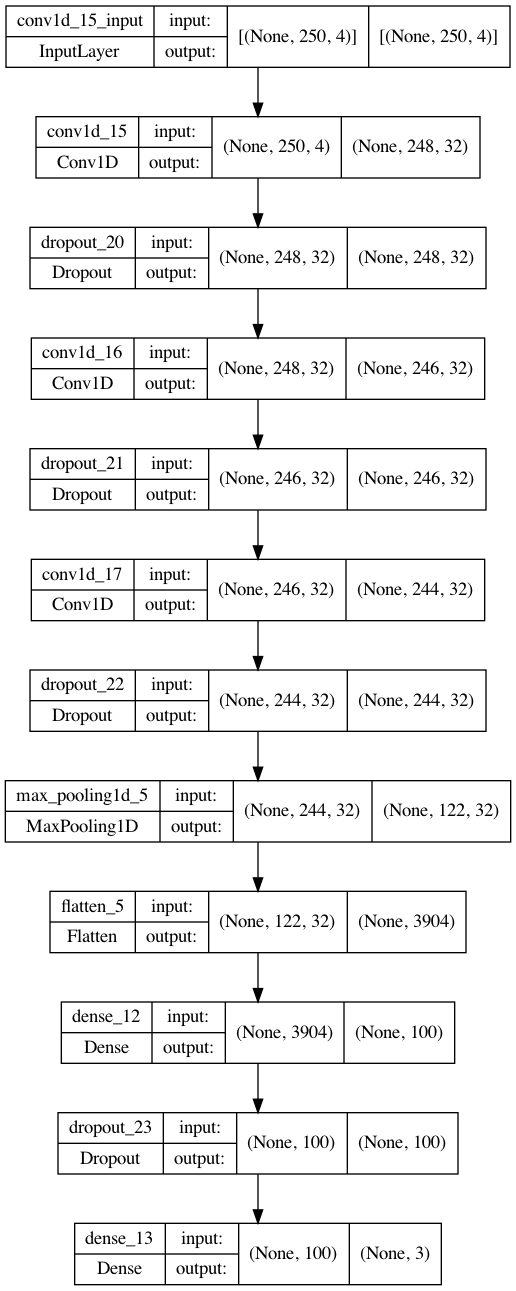

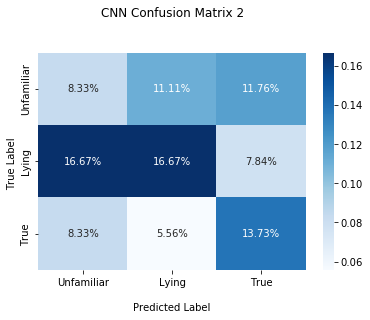

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

y_predictions = model.predict(
    x = X_test_NN
)
rounded_predictions = np.argmax(y_predictions, axis = 1)
cm = confusion_matrix(y_test, rounded_predictions, normalize='pred')
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_title('CNN Confusion Matrix 2\n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label ');
ax.xaxis.set_ticklabels(['Unfamiliar','Lying','True'])
ax.yaxis.set_ticklabels(['Unfamiliar','Lying','True'])

perc_acc = np.array(cm/np.sum(cm)).flatten()
acc_score = perc_acc[0] + perc_acc[4] + perc_acc[8]
print('The accuracy score for this CNN is', acc_score*100, '%')


from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [40]:
n_0 = min_shape
n_1 = 4
import keras
from keras import Sequential
from keras.layers import Conv1D
from keras import layers
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=(n_0, n_1)))
model.add(keras.layers.Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPooling1D(3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, "relu"))
model.add(keras.layers.Dense(100, "relu"))
model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(3, "softmax"))

import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(X_train_NN, y_train_NN, epochs=150, batch_size=20, validation_data=(X_test_NN, y_test_NN))

Epoch 1/150
2/2 [==============================] - 1s 314ms/step - loss: 1.4162 - accuracy: 0.4667 - val_loss: 1.1084 - val_accuracy: 0.3704
Epoch 2/150
2/2 [==============================] - 0s 102ms/step - loss: 1.3976 - accuracy: 0.2667 - val_loss: 1.1036 - val_accuracy: 0.3333
Epoch 3/150
2/2 [==============================] - 0s 86ms/step - loss: 1.5476 - accuracy: 0.2333 - val_loss: 1.1005 - val_accuracy: 0.2963
Epoch 4/150
2/2 [==============================] - 0s 69ms/step - loss: 1.3732 - accuracy: 0.2333 - val_loss: 1.0987 - val_accuracy: 0.2963
Epoch 5/150
2/2 [==============================] - 0s 71ms/step - loss: 1.3186 - accuracy: 0.2667 - val_loss: 1.0968 - val_accuracy: 0.3704
Epoch 6/150
2/2 [==============================] - 0s 67ms/step - loss: 1.2001 - accuracy: 0.3000 - val_loss: 1.0950 - val_accuracy: 0.3333
Epoch 7/150
2/2 [==============================] - 0s 67ms/step - loss: 1.3673 - accuracy: 0.3000 - val_loss: 1.0936 - val_accuracy: 0.3704
Epoch 8/150
2/2 [=

The accuracy score for this CNN is 28.253968253968253 %


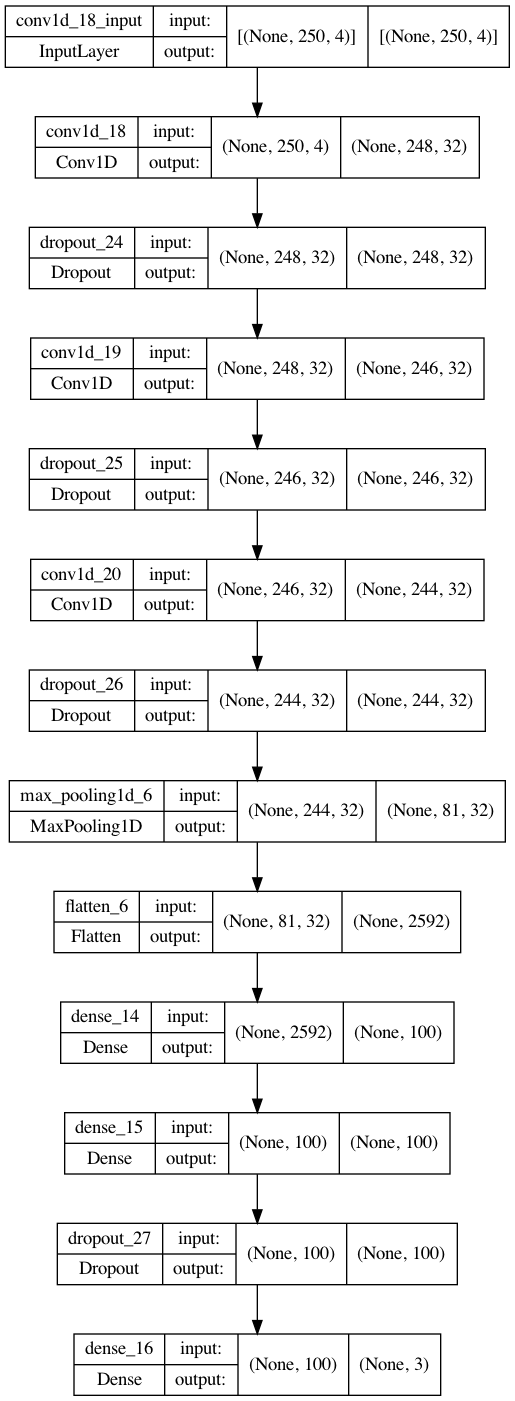

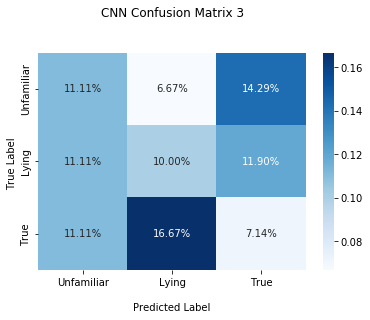

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

y_predictions = model.predict(
    x = X_test_NN
)
rounded_predictions = np.argmax(y_predictions, axis = 1)
cm = confusion_matrix(y_test, rounded_predictions, normalize='pred')
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_title('CNN Confusion Matrix 3\n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label ');
ax.xaxis.set_ticklabels(['Unfamiliar','Lying','True'])
ax.yaxis.set_ticklabels(['Unfamiliar','Lying','True'])

perc_acc = np.array(cm/np.sum(cm)).flatten()
acc_score = perc_acc[0] + perc_acc[4] + perc_acc[8]
print('The accuracy score for this CNN is', acc_score*100, '%')


from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [42]:
n_0 = min_shape
n_1 = 4
import keras
from keras import Sequential
from keras.layers import Conv1D
from keras import layers
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=(n_0, n_1)))
model.add(keras.layers.Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPooling1D(3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, "relu"))
model.add(keras.layers.Dense(100, "relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(3, "softmax"))

import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(X_train_NN, y_train_NN, epochs=150, batch_size=18, validation_data=(X_test_NN, y_test_NN))

Epoch 1/150
2/2 [==============================] - 4s 452ms/step - loss: 1.1565 - accuracy: 0.3667 - val_loss: 1.0936 - val_accuracy: 0.5556
Epoch 2/150
2/2 [==============================] - 0s 187ms/step - loss: 1.2959 - accuracy: 0.3000 - val_loss: 1.0931 - val_accuracy: 0.5185
Epoch 3/150
2/2 [==============================] - 0s 124ms/step - loss: 1.4306 - accuracy: 0.3000 - val_loss: 1.0925 - val_accuracy: 0.4815
Epoch 4/150
2/2 [==============================] - 0s 77ms/step - loss: 1.1237 - accuracy: 0.3667 - val_loss: 1.0927 - val_accuracy: 0.4815
Epoch 5/150
2/2 [==============================] - 0s 83ms/step - loss: 1.2438 - accuracy: 0.2000 - val_loss: 1.0929 - val_accuracy: 0.4074
Epoch 6/150
2/2 [==============================] - 0s 132ms/step - loss: 1.1209 - accuracy: 0.3333 - val_loss: 1.0929 - val_accuracy: 0.4074
Epoch 7/150
2/2 [==============================] - 0s 139ms/step - loss: 1.3032 - accuracy: 0.2667 - val_loss: 1.0929 - val_accuracy: 0.3704
Epoch 8/150
2/2

The accuracy score for this CNN is 37.797619047619044 %


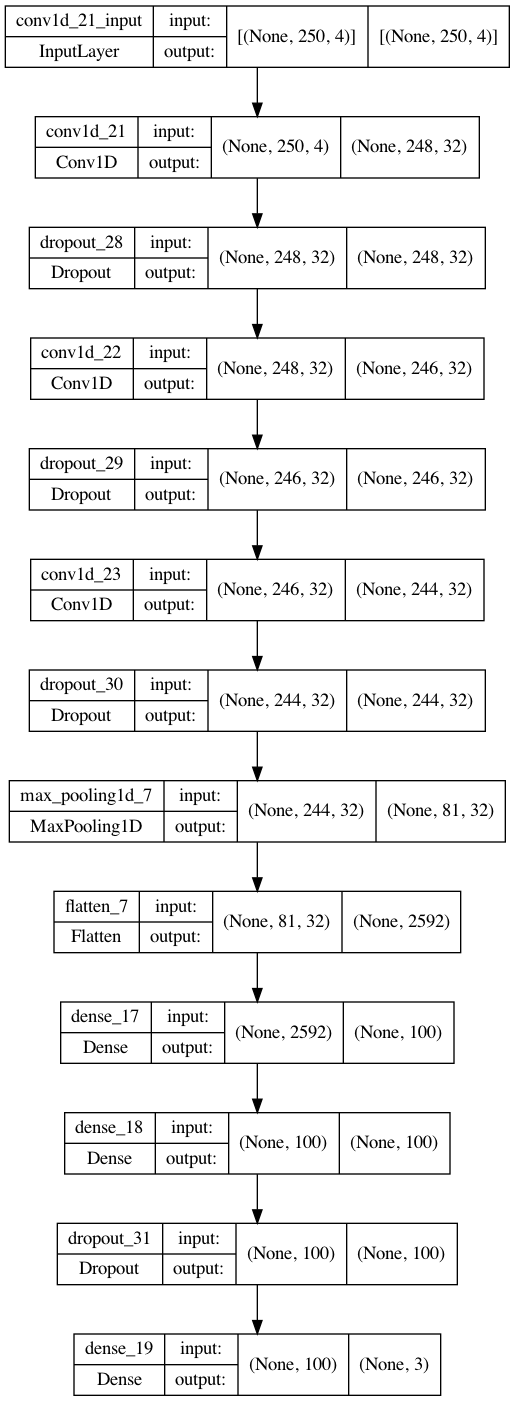

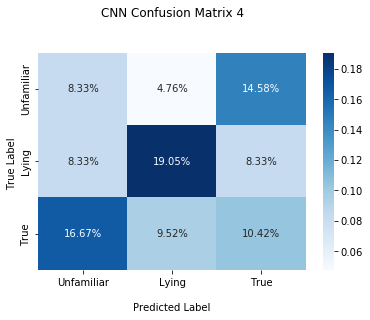

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

y_predictions = model.predict(
    x = X_test_NN
)
rounded_predictions = np.argmax(y_predictions, axis = 1)
cm = confusion_matrix(y_test, rounded_predictions, normalize='pred')
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_title('CNN Confusion Matrix 4\n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label ');
ax.xaxis.set_ticklabels(['Unfamiliar','Lying','True'])
ax.yaxis.set_ticklabels(['Unfamiliar','Lying','True'])

perc_acc = np.array(cm/np.sum(cm)).flatten()
acc_score = perc_acc[0] + perc_acc[4] + perc_acc[8]
print('The accuracy score for this CNN is', acc_score*100, '%')


from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

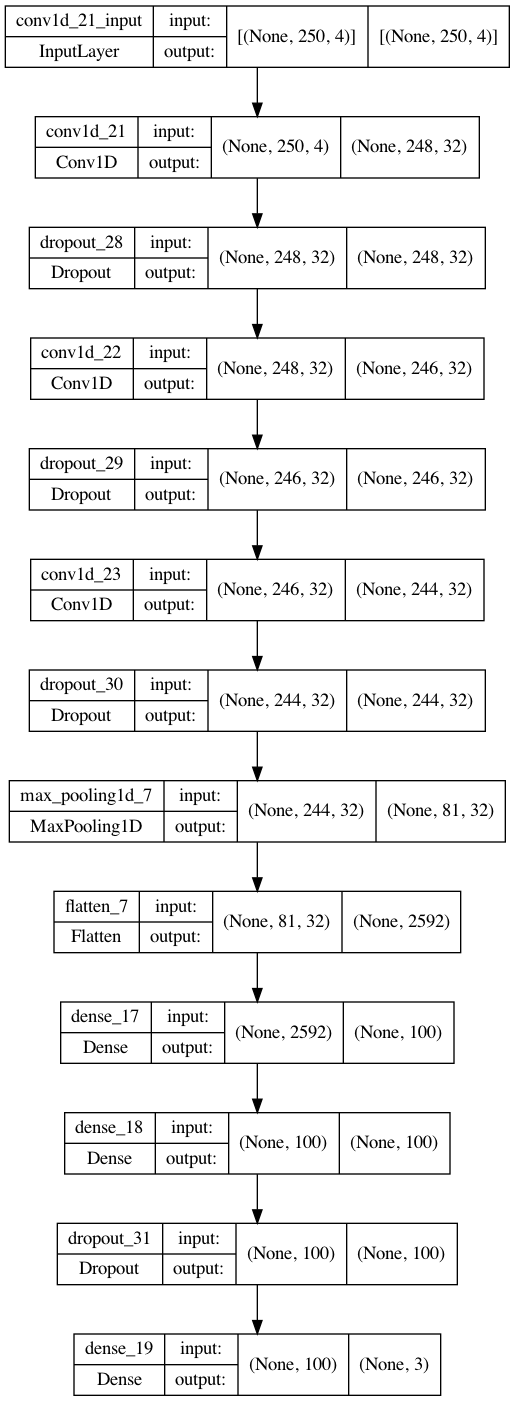

In [44]:


from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [45]:
import pydot